# 3. NYC Taxi: Прогнозирование большого количества рядов

Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому вы не сможете вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, вам предстоит кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера.

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок в июне:
$$Q_{june} = \frac1{R* 715 * 6} \sum\limits_{r=1}^{R}  \sum_{T=2016.05.31\,23:00}^{2016.06.30\,17:00}  \sum_{i=1}^6 \left| \hat{y}_{T|T+i}^r - y_{T+i}^r \right|.$$
$R$ — количество прогнозируемых рядов, 715 — количество перебираемых концов истории.

Построенные прогнозы вам предстоит загрузить на kaggle. К сожалению, в формате kaggle сложно организовать конкурс по прогнозированию временных рядов в традиционном виде, с отложенным тестом и пересчётом лидерборда, поскольку прогнозы необходимо строить со скользящим концом истории. Но цель использования kaggle в этом проекте — не победа в конкурсе; вы всегда можете загрузить истинные данные за июнь и получить первое место. Цель в том, чтобы посмотреть, какие модели, решения и признаки использовали ваши коллеги, и понять, какие из них стоит попробовать и вам.

Чтобы сдать задание, выполните следующую последовательность действий.

1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!
2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.
3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.
4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).
5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров $p,d,q,P,D,Q$ — так, как это делалось на прошлой неделе. **Не используйте данные за последний имеющийся месяц — май и июнь 2016!**
6. Для каждой из $R$ географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
$$Q_{may} =\frac1{R* 739* 6} \sum\limits_{r=1}^{R} \sum_{T=2016.04.30\,23:00}^{2016.05.31\,17:00} \sum_{i=1}^6 \left| \hat{y}^r_{T|T+i} - y_{T+i}^r \right|.$$
7. Для каждой из $R$ географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.
8. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.
9. Загрузите ноутбук в форму.

## Подготовка

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
#import statsmodels.stats.api as sms
import scipy as sc
from sklearn import metrics 
from sklearn.manifold import TSNE
import itertools
#import os
from glob import glob
import pickle
from time import time
from tqdm import tqdm_notebook
from pandas.tseries.holiday import USFederalHolidayCalendar
import warnings
warnings.filterwarnings('ignore')

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
%%time

# загружаем данные (за 6 месяцев)
f_lst = glob('agr_tripdata_*.pkl')
data = pd.DataFrame()
for f in f_lst:
    data = data.append(pd.read_pickle(f))
print(data.shape)

#data = pd.read_pickle('agr_tripdata_2016-04.pkl')
data.info()

(10920000, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10920000 entries, 0 to 1799999
Data columns (total 3 columns):
date    datetime64[ns]
bins    int16
numb    int16
dtypes: datetime64[ns](1), int16(2)
memory usage: 208.3 MB
Wall time: 2.25 s


In [6]:
data.head()

,date,bins,numb
0,2015-11-01,1,0
1,2015-11-01,2,0
2,2015-11-01,3,0
3,2015-11-01,4,0
4,2015-11-01,5,0


## 1. Подготовка таблицы по заданному формату

In [7]:
# загружаем коды 102-ух ячеек, отобранных для анализа
cells_id = pd.read_csv('keys.csv', names=['id'], dtype={'id':'int16'})
cells_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 1 columns):
id    102 non-null int16
dtypes: int16(1)
memory usage: 284.0 bytes


In [8]:
# выбираем необходимые ячейки
sample = data[data.bins.isin(cells_id.values)]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445536 entries, 1074 to 1799667
Data columns (total 3 columns):
date    445536 non-null datetime64[ns]
bins    445536 non-null int16
numb    445536 non-null int16
dtypes: datetime64[ns](1), int16(2)
memory usage: 8.5 MB


In [9]:
# разворачиваем
data_agr = sample.set_index(['date', 'bins']).unstack()
data_agr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2015-11-01 00:00:00 to 2016-04-30 23:00:00
Columns: 102 entries, (numb, 1075) to (numb, 2168)
dtypes: int16(102)
memory usage: 904.3 KB


In [10]:
# результат
data_agr.ix[:5, :5]

numb                    
bins                1075 1076 1077 1125 1126
date                                        
2015-11-01 00:00:00   53  172   46  108  327
2015-11-01 01:00:00  112  235   32  173  666
2015-11-01 02:00:00   25   60    9   57  229
2015-11-01 03:00:00   21   23    8   30  137
2015-11-01 04:00:00   19   23   10   20   65

## 2. Стандартизация столбцов

In [11]:
# стандартизируем
data_std = (data_agr.numb - data_agr.numb.mean())/data_agr.numb.std()
data_std.ix[:5, data_std.columns[:5]]

bins,1075,1076,1077,1125,1126
date,,,,,
2015-11-01 00:00:00,-0.164608,0.508689,-0.622872,1.085404,1.509426
2015-11-01 01:00:00,1.389579,1.275782,-0.864755,2.714129,4.964897
2015-11-01 02:00:00,-0.902189,-0.855033,-1.262135,-0.192519,0.510499
2015-11-01 03:00:00,-1.007557,-1.305548,-1.279412,-0.869066,-0.427269
2015-11-01 04:00:00,-1.060242,-1.305548,-1.244858,-1.119639,-1.161175


## 3. Кластеризация

In [12]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [13]:
# будет интерактивчик
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

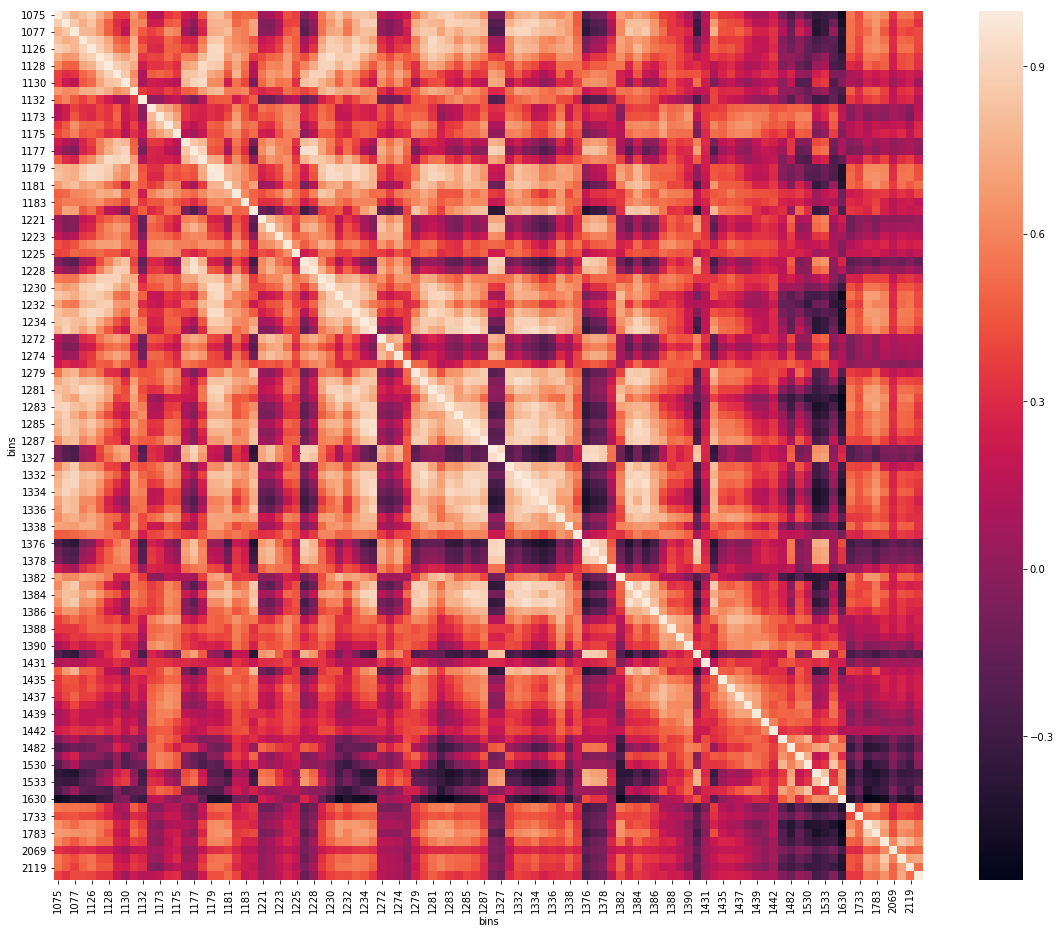

In [14]:
# это коврик для медитации...
fig, axes = plt.subplots(figsize=(20,16))
sns.heatmap(data_std.corr(), square=True);

Wall time: 1.79 s


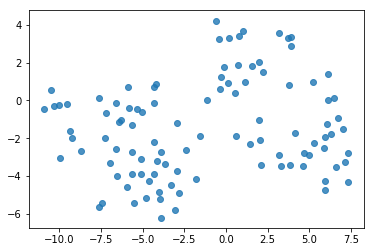

In [15]:
%%time
# для начала отобразим в двумерное пространство на наши многомерные данные
tsne_obj = TSNE(random_state=5)
tsne_representation = tsne_obj.fit_transform(data_std.T)

#fig = plt.subplots(figsize=(15,10))
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], alpha=0.8)

"""
так себе облачко, будут проблемы...
"""
pass

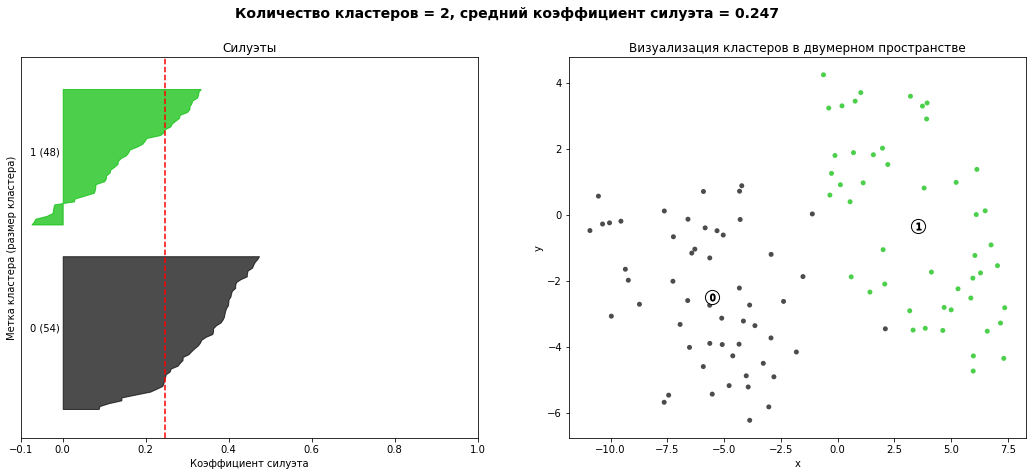

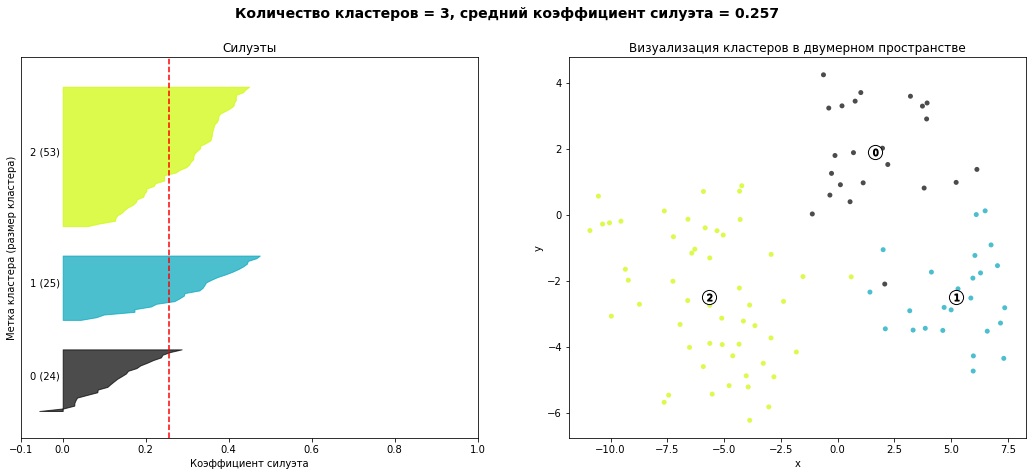

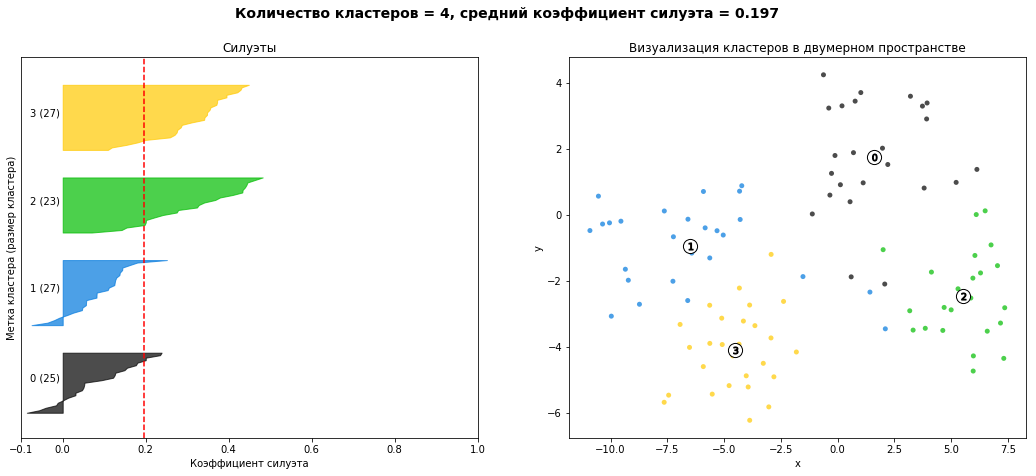

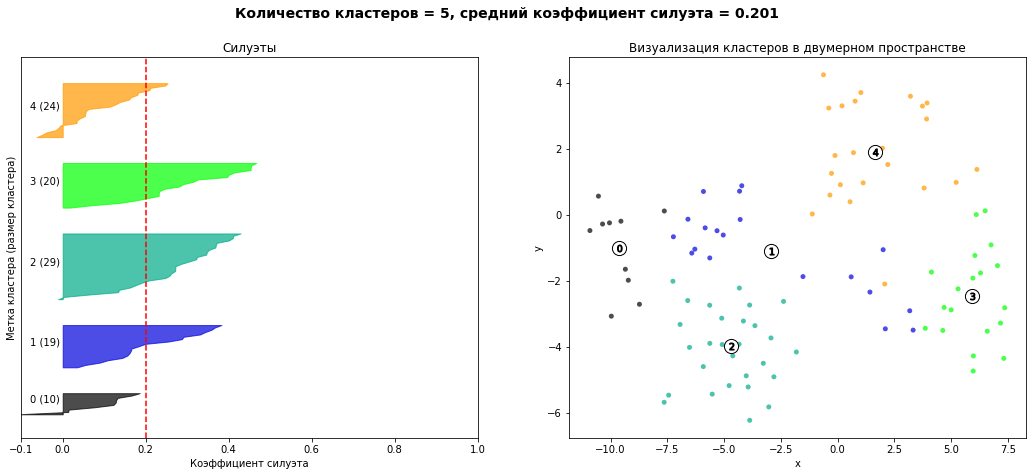

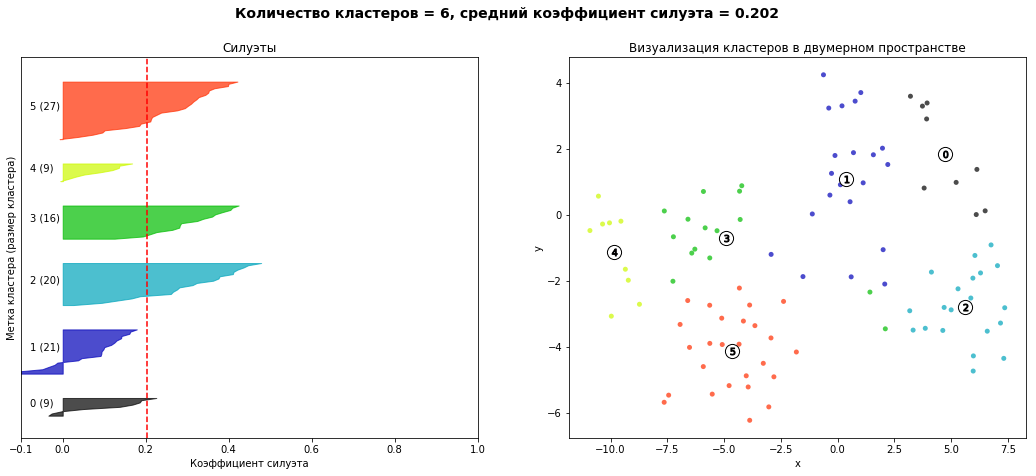

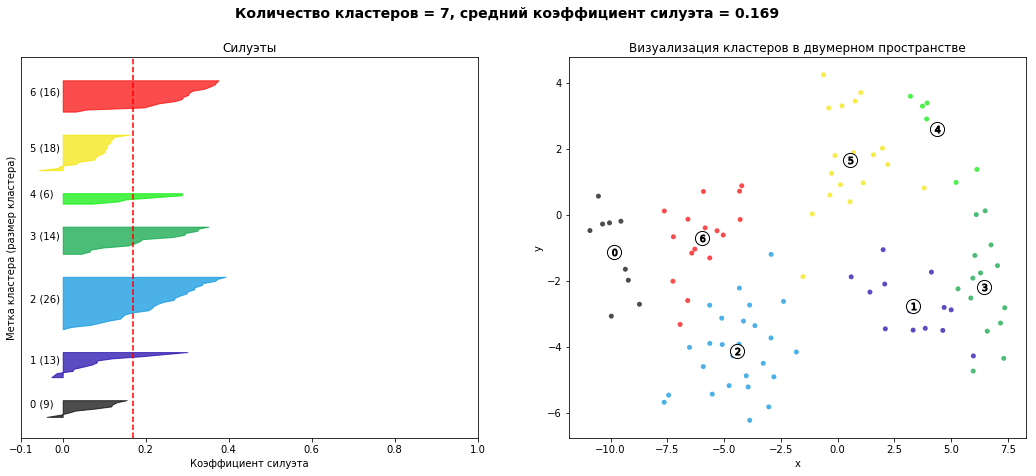

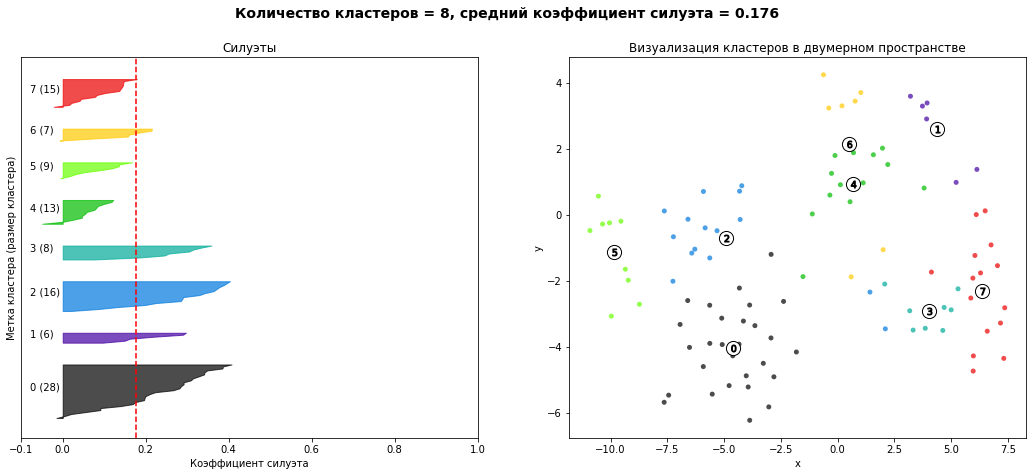

Wall time: 4.15 s


In [16]:
%%time
# имеем 102 объекта; с кластерами в задании призывали не мельчить,
# поэтому ограничимся максимум восемью, и рассмотрим варианты
# мудрить не будем - KMeans!
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    
    # заготовка картинки
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data_std.T) + (n_clusters + 1) * 10])
    
    # применим KMeans к наши данным
    model = KMeans(n_clusters=n_clusters, random_state=5)
    preds = model.fit_predict(data_std.T)
    
    # считаем средний коэффициент силуэта, и по всем значениям
    silhouette_avg = silhouette_score(data_std.T, preds)
    sample_silhouette_values = silhouette_samples(data_std.T, preds)

    # рисуем графики силуэтов (слева)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[preds == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # метка и размер кластера
        ax1.text(-0.08, y_lower + 0.5 * size_cluster_i, str(i) + " (" + str(size_cluster_i) +")")

        y_lower = y_upper + 10 
        
    ax1.set_title("Силуэты")
    ax1.set_xlabel("Коэффициент силуэта")
    ax1.set_ylabel("Метка кластера (размер кластера)")

    # линия среднего коэффициента силуэта
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # рисуем облачка отображения в двумерное пространство
    colors = cm.spectral(preds.astype(float) / n_clusters)
    ax2.scatter(tsne_representation[:, 0], 
                tsne_representation[:, 1], marker='.', s=100, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    # рассчитаем и отобразим центры кластеров
    centers = np.array([tsne_representation[preds == x].mean(axis=0) for x in set(preds)])
    ax2.scatter(centers[:,0], 
                centers[:,1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Визуализация кластеров в двумерном пространстве")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")

    plt.suptitle("Количество кластеров = {0}, средний коэффициент силуэта = {1:.3f}"
                 .format(n_clusters, silhouette_avg),
                 fontsize=14, fontweight='bold')

    plt.show()

**Выводы:**
Облачко было так себе, соответственно коэффициенты силуэта не очень высокие. Во всех вариантах так и хочется что-то подкорректировать вручную. Это видно и на двумерном отображении, и подтверждается отрицательными хвотами силуэтов. Может что-то переразметим вручную... Варианты 3-7 берем на заметку, разбираться будем в процессе построения прогноза. 

Добавим немного интерактива

In [17]:
# добавим немного интерактива (надо настроить слайдер)
for_plt = pd.DataFrame(list(zip(tsne_representation[:, 0], 
                                tsne_representation[:, 1], 
                                list(data_std.columns),
                                preds)), columns=['x', 'y', 'id', 'clust'])

c=['hsl('+str(360/(max(set(preds))+1)*(h+1))+',50%,50%)' for h in preds]

trace = go.Scatter(
    x = for_plt['x'],
    y = for_plt['y'],
    mode = 'markers',
    text = for_plt['id'],
    marker = dict(size= 8,
                  color= c,
                  opacity= 0.6), name = for_plt['clust']
)

layout = dict(title = 'Визуализация кластеров в двумерном пространстве',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend = False
             )

fig = dict(data=[trace], layout=layout)

#data = [trace]

iplot(fig)

euclidean  -  1.56  s
cityblock  -  1.64  s
sqeuclidean  -  1.61  s
correlation  -  1.5  s
chebyshev  -  1.5  s
braycurtis  -  1.55  s


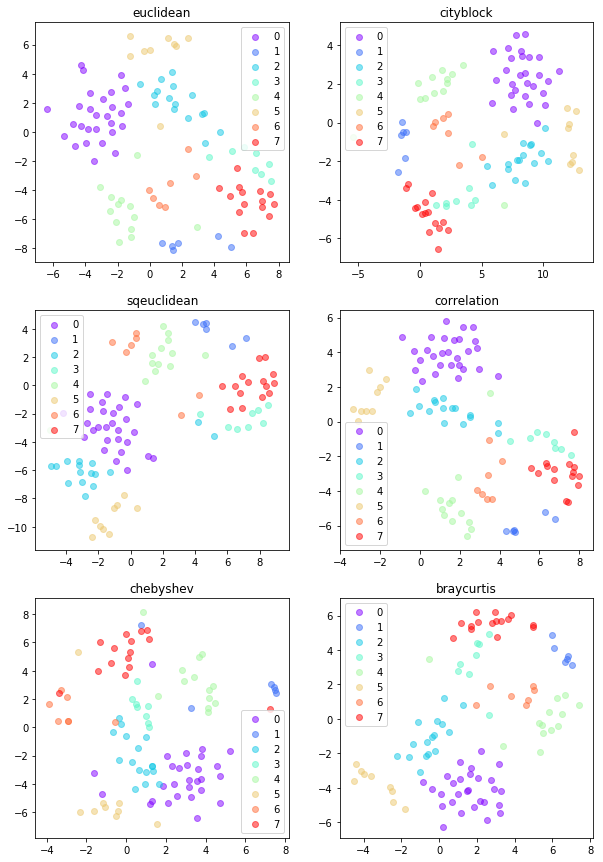

In [18]:
metrics = np.array([['euclidean', 'cityblock'],
                    ['sqeuclidean', 'correlation'], 
#                    ['hamming', 'jaccard'],
                    ['chebyshev', 'braycurtis'],
#                    ['canberra', 'matching'],
#                    ['dice', 'kulsinski'],
#                    ['rogerstanimoto', 'russellrao'],
#                    ['sokalmichener', 'sokalsneath']
                   ])

fig, axes = plt.subplots(metrics.shape[0], metrics.shape[1], figsize=(10, 5*metrics.shape[0]))

colors = cm.rainbow(np.linspace(0, 1, len(set(preds))))

for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        _strt = time()
        tsne_obj = TSNE(metric = metrics[i,j], random_state=321)
        tsne_representation = tsne_obj.fit_transform(data_std.T)
        _fin = time()
        print (metrics[i,j], ' - ', round(_fin-_strt, 2), ' s')

        for y, c in zip(set(preds), colors):
            axes[i,j].scatter(tsne_representation[preds==y, 0], 
                        tsne_representation[preds==y, 1], c=c, alpha=0.5, label=str(y))
        axes[i,j].set_title(metrics[i,j])
        axes[i,j].legend()

## 4. Выбираем типичный ряд кластера

In [19]:
# выбираем ячейки, наиболее близкие к центрам своих кластеров
# начнем с тройки

model = KMeans(n_clusters=3, random_state=0)
preds = model.fit_predict(data_std.T)

clust_centers = []
for i in set(preds):
    sample = data_std[data_std.columns[preds == i]].T
    idx = argmin([euclidean_distances([x, model.cluster_centers_[i]])[0,1] for x in sample.values])
    clust_centers.append(data_std.columns[preds == i][idx])
    
print('ячейки, наиболее близкие к центрам своих кластеров: ', clust_centers)

ячейки, наиболее близкие к центрам своих кластеров:  [1234, 1177, 1387]


## 5. Подбор гиперпараметров $p,d,q,P,D,Q$

In [20]:
# выбираем данные по выбранной ячейке
def prepare_data(data, n_bin):
    cell_data = pd.DataFrame(data[n_bin])
    cell_data.columns = ['numb']

    # рассмотрим STL-декомпозицию
    plt.figure(figsize(18,12))
    sm.tsa.seasonal_decompose(cell_data).plot()
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(cell_data.numb/60)[1])
    
    return cell_data

In [21]:
# процедура формирования массива признаков 
def gen_features(cell_data, ii):
    # генерируем значения
    sin_i = [np.sin(np.array(range(1, len(cell_data)+1))*2*np.pi*i/168)
             for i in ii]
    cos_i = [np.cos(np.array(range(1, len(cell_data)+1))*2*np.pi*i/168)
             for i in ii]
    # наименования переменны x_[_s, _c] - синус/косинус [_i] - множитель
    name_s = ['x_s_'+str(i) for i in ii]
    name_c = ['x_c_'+str(i) for i in ii]
    # соберем в таблицу, добавим отклик и проиндексируем
    features = pd.DataFrame(sin_i + cos_i).T
    features.columns = name_s + name_c
    features['y'] = cell_data.numb.values
    features.index = cell_data.numb.index
    
    return features

Критерий Дики-Фуллера: p=0.000000


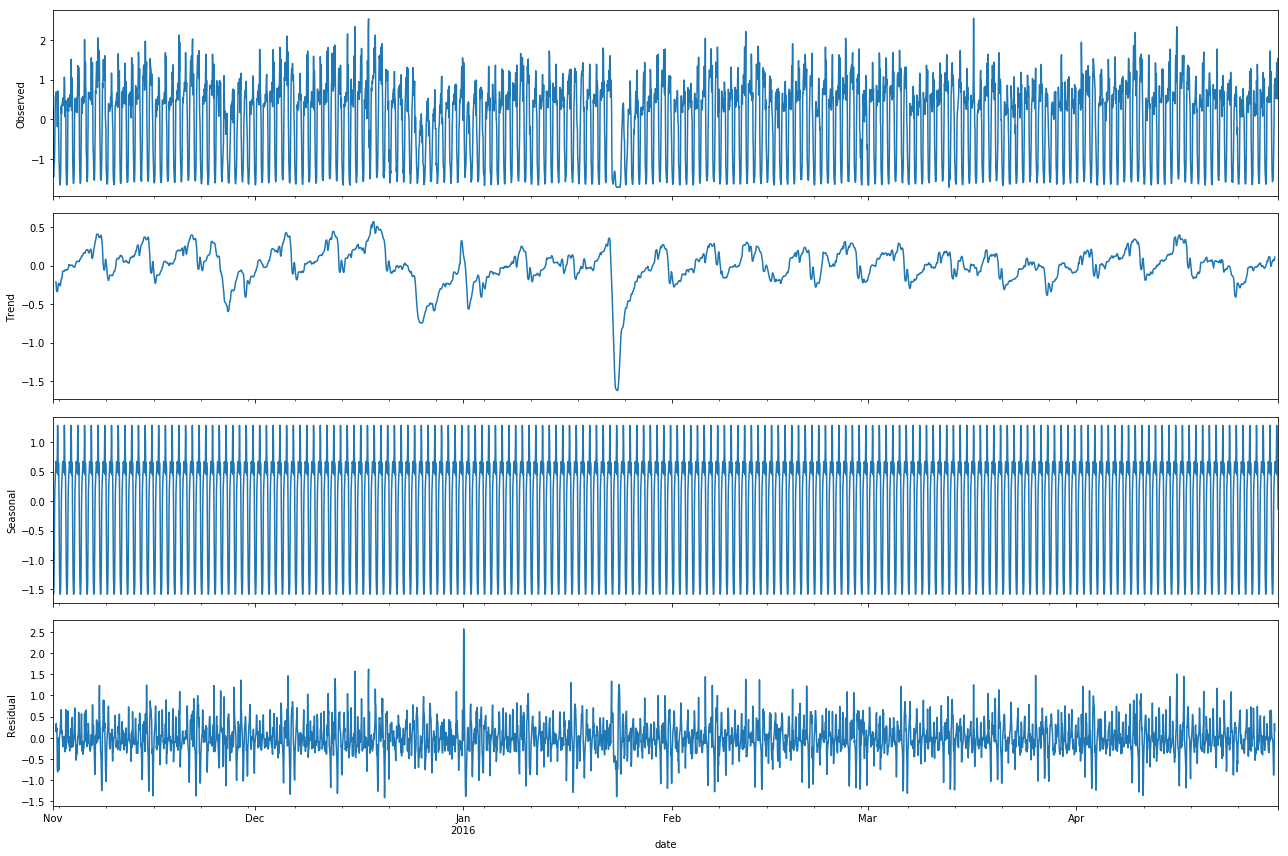

In [22]:
# формируем признаки
#[1234, 1177, 1387]
cell_data = prepare_data(data_std, 1234)

In [23]:
holidays = USFederalHolidayCalendar().holidays(start=cell_data.index.min(), end=cell_data.index.max())
holihours = np.array([pd.date_range(data, periods=24, freq='h') for data in holidays]).ravel()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.644
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           1.81e-05
Time:                        22:06:37   Log-Likelihood:                -6174.5
No. Observations:                4368   AIC:                         1.237e+04
Df Residuals:                    4355   BIC:                         1.246e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0442      0.026  

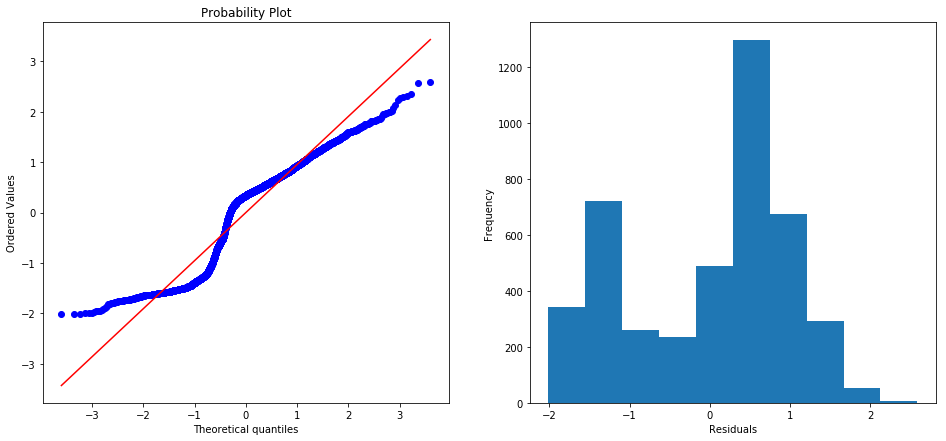

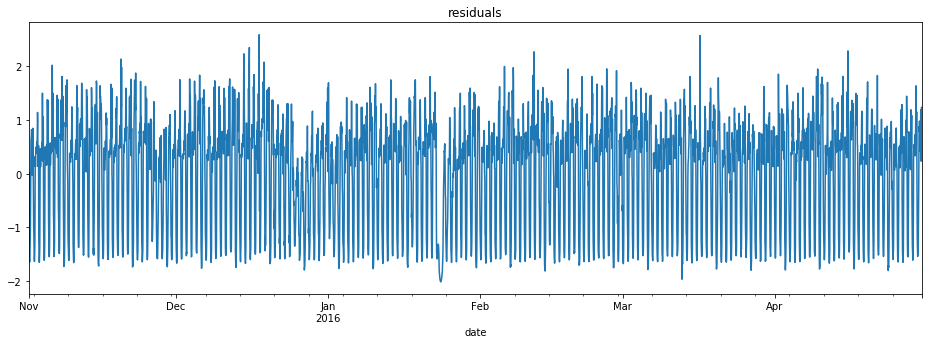

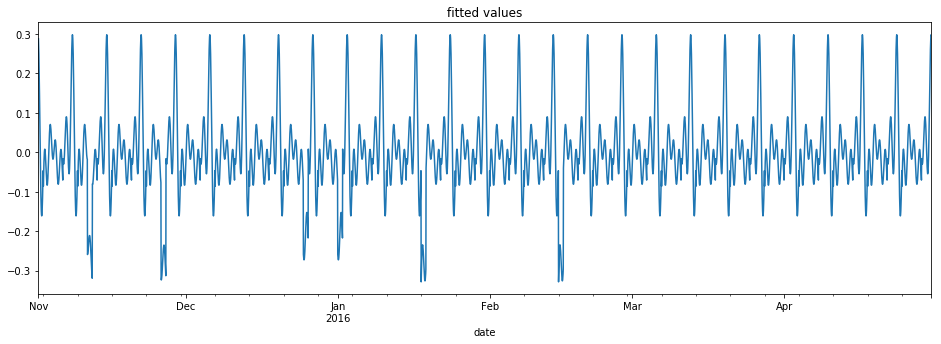

In [92]:
ii = range(2,7)
features = gen_features(cell_data, ii)

# добавим бинарный признак выходных
features['weekend'] = features.index.weekday
features['weekend'] = (features['weekend'] < 4) # сначала выделял выходные, потом инвертировал (не переименовал)
#features['weekday'] = features.index.weekday
#features = pd.get_dummies(features, columns=['weekday'])
# от признаков Рождества и периода снежного шторма отказался
features['holidays'] = features.index.isin(holihours)
#features['anomality'] = features.index.isin(pd.date_range('2016-01-23', periods=2*24, freq='h'))

# воспользуемся statmodels
m1 = smf.ols('y~'+'+'.join(features.columns.drop(['y'])), 
             data=features)
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals')
plt.figure(figsize(16,5))
fitted.resid.plot()
plt.title('residuals')
plt.figure(figsize(16,5))
fitted.fittedvalues.plot()
plt.title('fitted values')
pylab.show()

In [31]:
def differ(residuals, feature_name, diff_params=[1], n_iter=1):
    n = len(diff_params)
    # шаблон нового имени name_параметр[_параметр[...]]
    new_name = feature_name + '_' + str(diff_params[0])
    
    # дифференцируем
    residuals[new_name] = residuals[feature_name] - residuals[feature_name].shift(diff_params[0])
    
    # выводим критерий Дики-Фуллера и STL-декомпозицию для каждого этапа дифференцирования 
    plt.figure(figsize(15,10))
    sm.tsa.seasonal_decompose(residuals[new_name].dropna()).plot()
    plt.suptitle('Итерация дифференцирования - {0}, период - {1}'.format(n_iter, diff_params[0]),
                 fontsize=14, fontweight='bold')
    print("Критерий Дики-Фуллера (итерация - {0}, период - {1}): p={2}"
          .format(n_iter, diff_params[0], sm.tsa.stattools.adfuller(residuals[new_name].dropna())[1]));
    n_iter +=1
    
    # вызываем рекуррентно, если не последняя итерация
    if n > 1:
        differ(residuals, new_name, diff_params=diff_params[1:], n_iter=n_iter) 
    else:
        # выводим коррелограммы для последнего этапа дифференцирования
        plt.figure(figsize(18,10))
        ax = plt.subplot(211)
        sm.graphics.tsa.plot_acf(residuals[new_name].dropna().values.squeeze(), lags=50, ax=ax, zero=False)
        pylab.show()
        ax = plt.subplot(212)
        sm.graphics.tsa.plot_pacf(residuals[new_name].dropna().values.squeeze(), lags=50, ax=ax, zero=False)
        pylab.show()

Критерий Дики-Фуллера (итерация - 1, период - 168): p=1.745237529492568e-12
Критерий Дики-Фуллера (итерация - 2, период - 24): p=2.4827658577230983e-25
Критерий Дики-Фуллера (итерация - 3, период - 1): p=4.093374113231261e-30


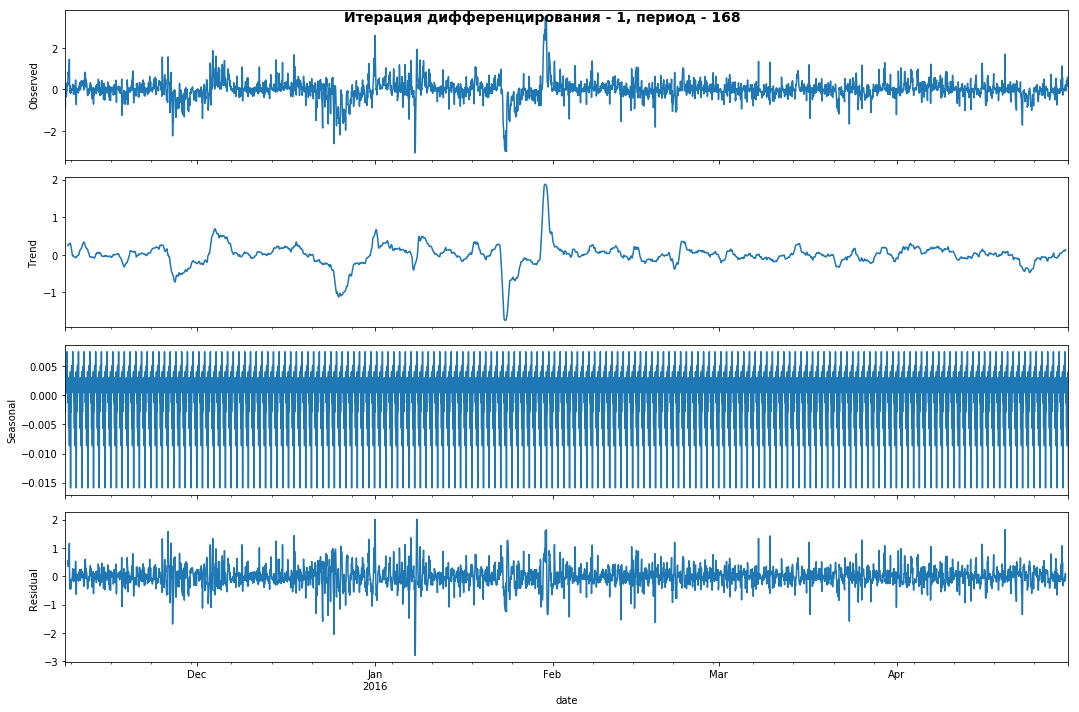

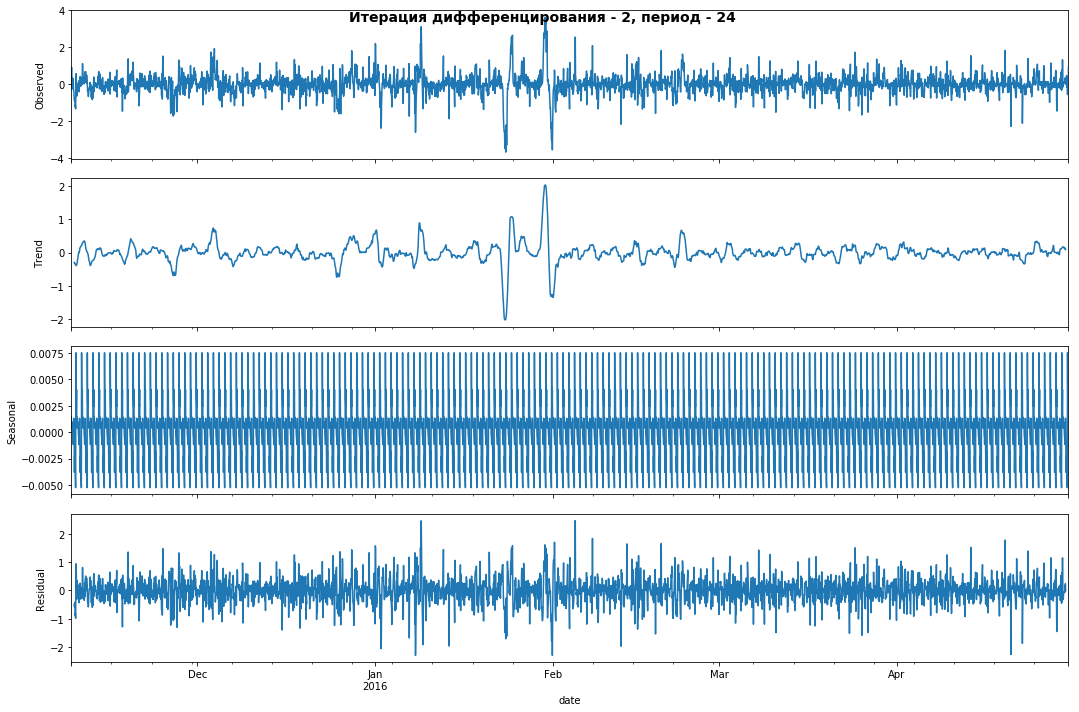

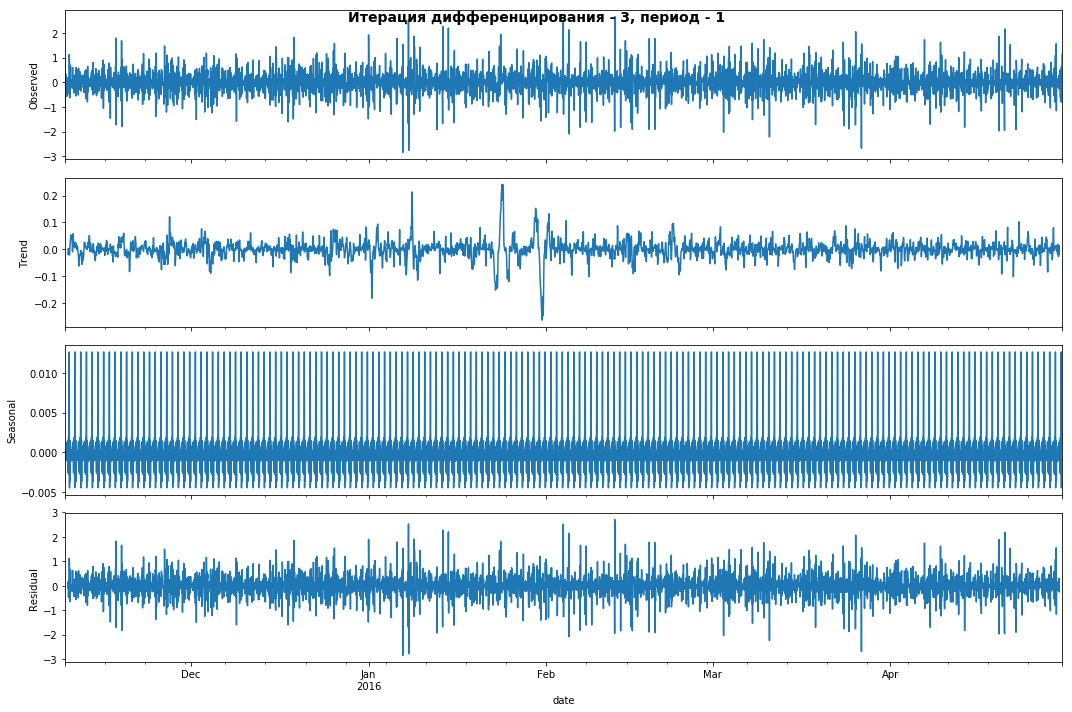

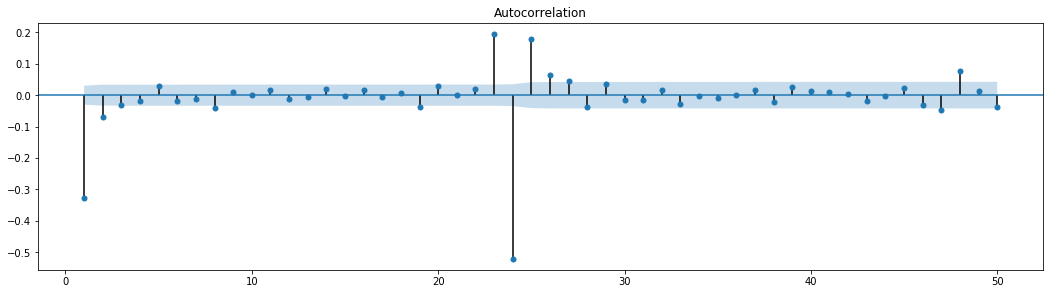

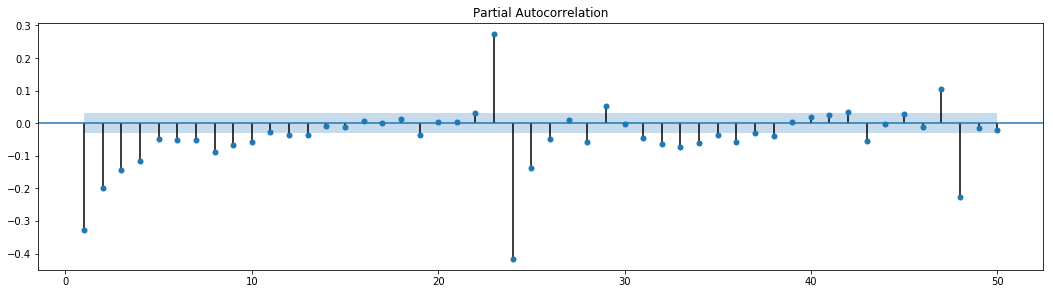

In [96]:
residuals = pd.DataFrame(fitted.resid, columns=['resid'])
differ(residuals, 'resid', diff_params=[168,24,1])

In [99]:
ps = range(0, 11)
d = 1            # простое
qs = range(0, 2) 
Ps = range(0, 2)
D = 2           # сезонное
Qs = range(0, 2)

parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

88

In [135]:
cell_data_r = pd.DataFrame(data_agr.numb[1234])
cell_data_r.columns = ['numb']
cell_data_r.head()

,numb
date,
2015-11-01 00:00:00,376
2015-11-01 01:00:00,425
2015-11-01 02:00:00,83
2015-11-01 03:00:00,62
2015-11-01 04:00:00,55


In [108]:
%%time
# заготовка из C5W1
results = []
best_aic = float("inf")

# c tqdm не так утомительно ждать; если не установлен, переставьте комментарий
#for param in parameters_list:
for param in tqdm_notebook(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(cell_data_r, 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        exog=features[features.columns.drop(
                                            ['y'])].astype({'holidays':'int8','weekend':'int8'}),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                        ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

A Jupyter Widget

wrong parameters: (0, 0, 0, 0)

Wall time: 10h 49min 17s


In [136]:
%%time
# зададим параметры выбранной модели напрямую
best_model = sm.tsa.statespace.SARIMAX(cell_data_r, 
                                        order=(10, d, 1), 
                                        seasonal_order=(1, D, 1, 24),
                                        exog=features[features.columns.drop(
                                            ['y'])].astype({'holidays':'int8','weekend':'int8'}),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                        ).fit(disp=-1)

Wall time: 19min 55s


In [109]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters           aic
86  (10, 1, 1, 1)  48492.936125
78   (9, 1, 1, 1)  48587.155306
82  (10, 0, 1, 1)  48597.645630
70   (8, 1, 1, 1)  48608.042752
74   (9, 0, 1, 1)  48665.210158


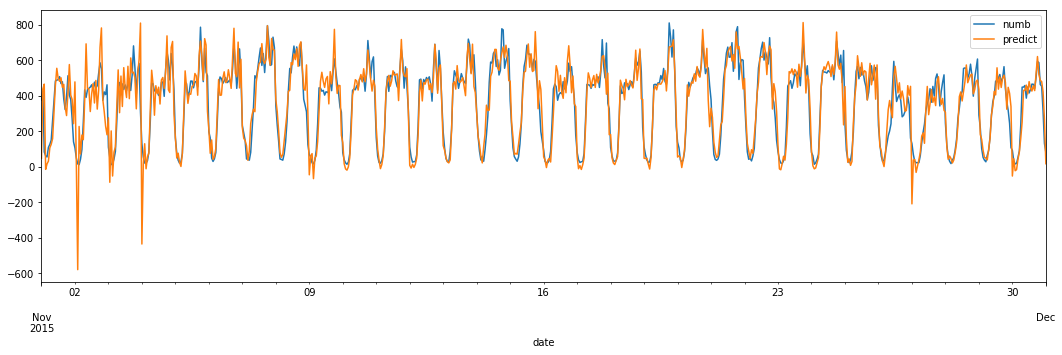

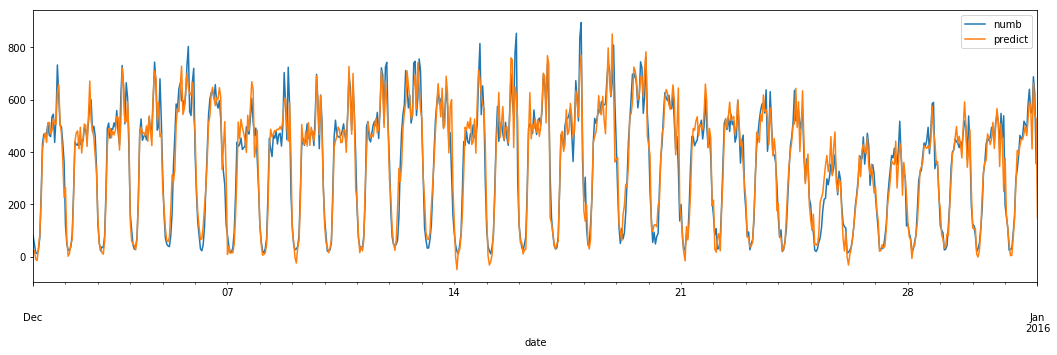

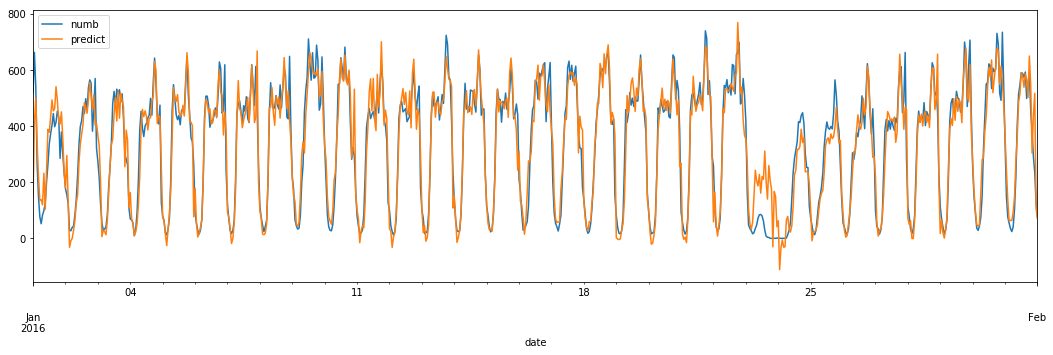

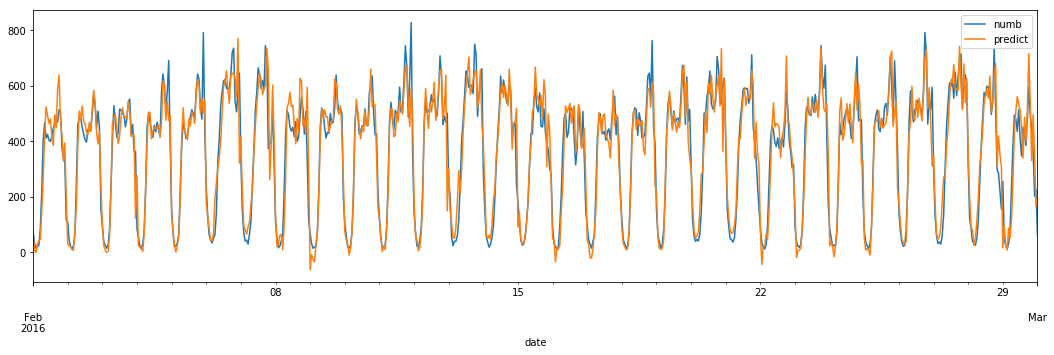

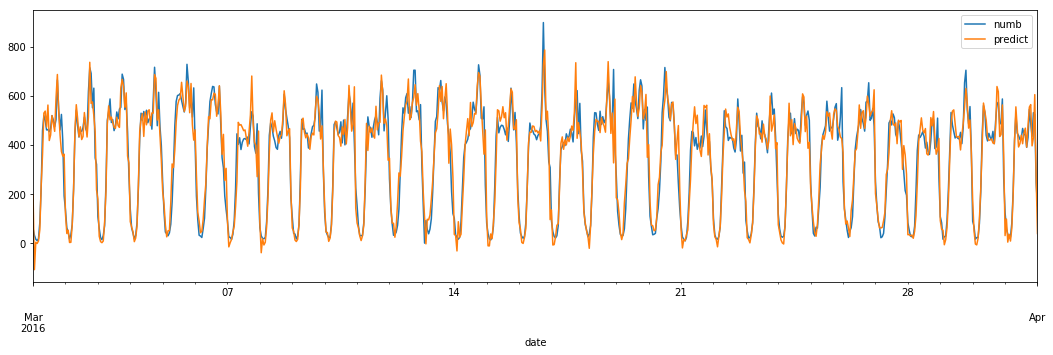

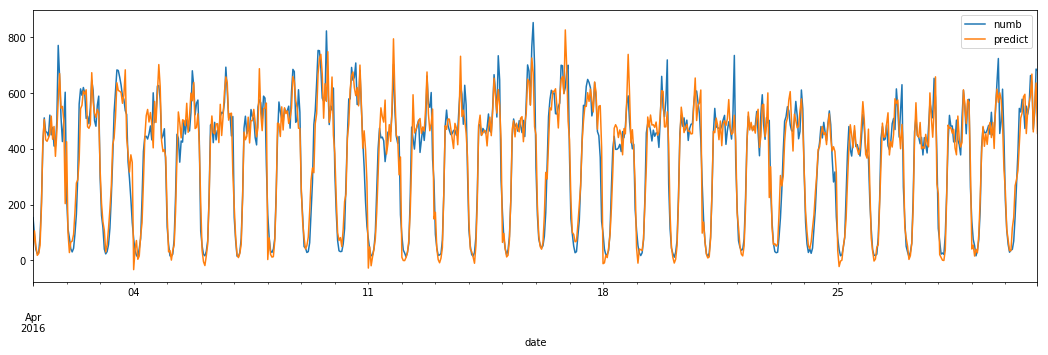

In [110]:
# разобьем график помесячно, так лучше видно
st = datetime.datetime.strptime("2015-11-01", "%Y-%m-%d")
for i in range(1,7):
    plt.figure(figsize(18,5))
    cell_data_r[st:st+relativedelta(months=1)].plot(label='data', legend=True)
    best_model.fittedvalues[st:st+relativedelta(months=1)].plot(label='predict', legend=True)
    st = st+relativedelta(months=1);

In [111]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                                numb   No. Observations:                 4368
Model:             SARIMAX(10, 1, 1)x(1, 2, 1, 24)   Log Likelihood              -24220.468
Date:                             Mon, 29 Jan 2018   AIC                          48492.936
Time:                                     09:10:49   BIC                          48658.870
Sample:                                 11-01-2015   HQIC                         48551.493
                                      - 04-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_s_2        -13.8233      4.249     -3.253      0.001     -22.151      -5.496
x_s_3          6.5387      

Критерий Стьюдента: p=0.831204
Критерий Дики-Фуллера: p=0.000000


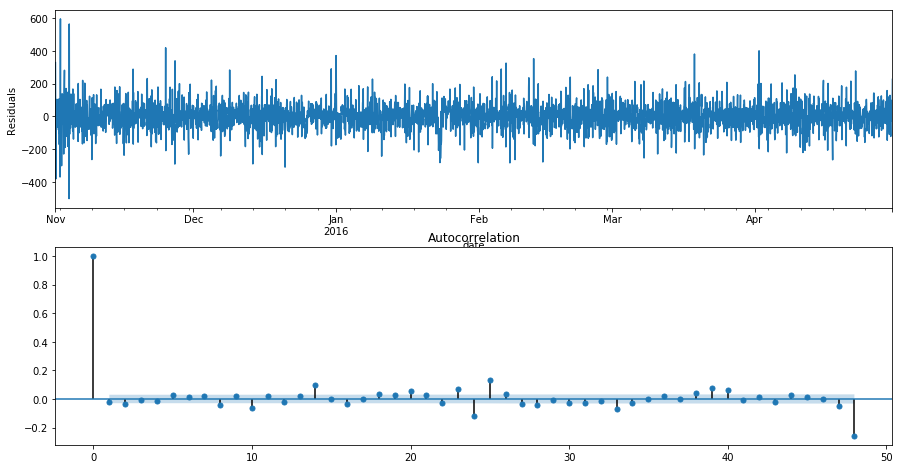

In [112]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[168+24*2:])[1])

In [83]:
print('среднечасовое значение поездок из выбранной зоны - {0:.2f}, корень из среднеквадратичной ошибки прогноза - {1:.2f}' 
      .format(cell_data_r.mean()[0], sqrt(metrics.mean_squared_error(cell_data_r, best_model.fittedvalues))))

AttributeError: 'numpy.ndarray' object has no attribute 'mean_squared_error'

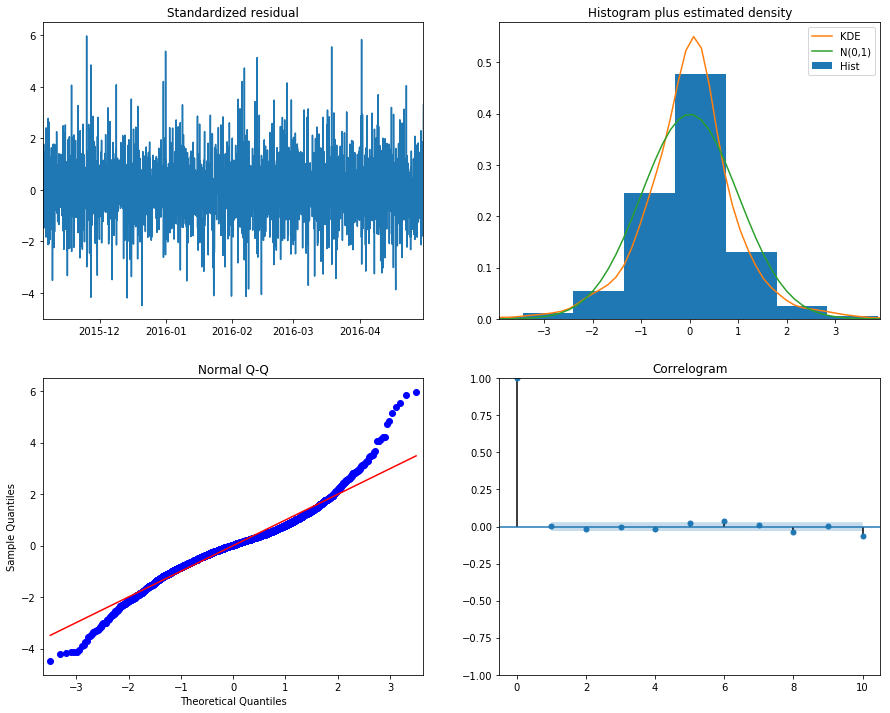

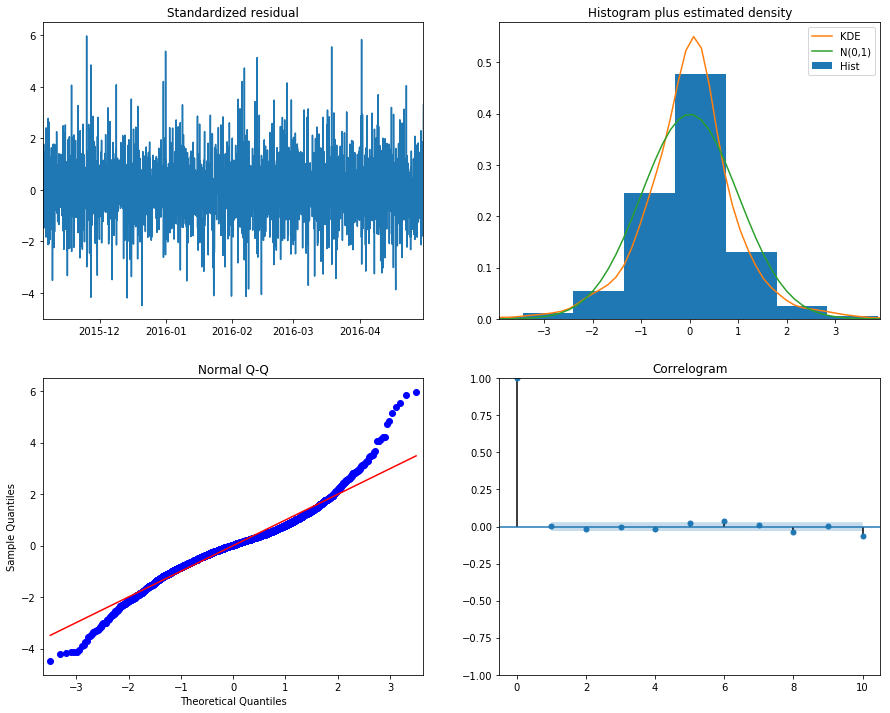

In [113]:
best_model.plot_diagnostics(figsize=(15, 12))

In [117]:
ii = range(2,7)
features_fut = gen_features(future, ii)
# добавим бинарный признак выходных
features_fut['weekend'] = features_fut.index.weekday
features_fut['weekend'] = (features_fut['weekend'] < 4) 
# от признаков Рождества и периода снежного шторма отказался
features_fut['holidays'] = features_fut.index.isin(holihours)
#features_fut['anomality'] = features_fut.index.isin(pd.date_range('2016-01-23', periods=2*24, freq='h'))

In [118]:
features_fut[features_fut.columns.drop(['y'])].head()

,x_s_2,x_s_3,x_s_4,x_s_5,x_s_6,x_c_2,x_c_3,x_c_4,x_c_5,x_c_6,weekend,holidays
2016-06-01 00:00:00,0.074730,0.111964,0.149042,0.185912,0.222521,0.997204,0.993712,0.988831,0.982566,0.974928,True,False
2016-06-01 01:00:00,0.149042,0.222521,0.294755,0.365341,0.433884,0.988831,0.974928,0.955573,0.930874,0.900969,True,False
2016-06-01 02:00:00,0.222521,0.330279,0.433884,0.532032,0.623490,0.974928,0.943883,0.900969,0.846724,0.781831,True,False
2016-06-01 03:00:00,0.294755,0.433884,0.563320,0.680173,0.781831,0.955573,0.900969,0.826239,0.733052,0.623490,True,False
2016-06-01 04:00:00,0.365341,0.532032,0.680173,0.804598,0.900969,0.930874,0.846724,0.733052,0.593820,0.433884,True,False


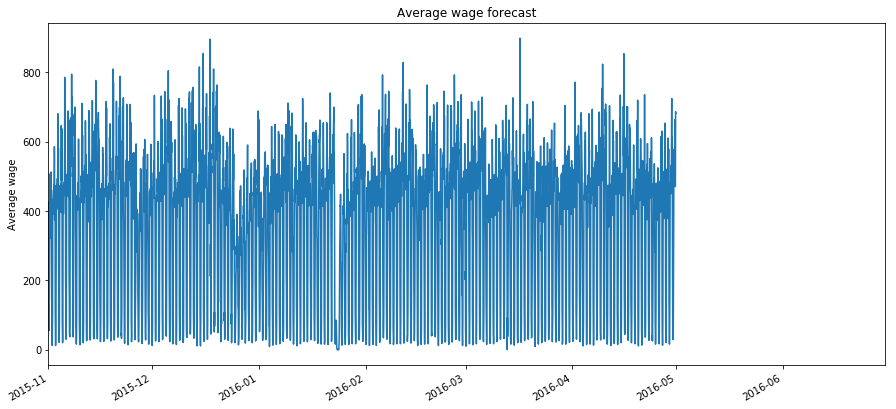

In [120]:
pr_per = 715 # горизонт прогноза

#data_agr_cell = data_agr['numb'][[1285]]
#data_agr_cell.columns = ['numb']


#date_list = [datetime.datetime.strptime("2015-06-01", "%Y-%m-%d") + relativedelta(hour=x) for x in range(0, pr_per)]
date_list = pd.date_range(start='2016-06-01', periods=pr_per, freq='h')
future = pd.DataFrame(index=date_list, columns= cell_data_r.columns)
cell_data_r = pd.concat([cell_data_r, future])
cell_data_r['forecast'] = best_model.predict(start=data_agr.shape[0], end=data_agr.shape[0] + pr_per - 1,
                                             exog=features_fut[features_fut.columns.drop(['y'])]
                                             .astype({'holidays':'int8', 'weekend':'int8'}))

plt.figure(figsize(15,7))
cell_data_r.numb.plot()
cell_data_r.forecast.plot(color='r')
plt.ylabel('Average wage')
plt.title('Average wage forecast')
pylab.show()